In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("/content/"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('/content/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/plates')
    
print('After zip extraction:')
print(os.listdir("/content/plates"))

['.config', 'plates.zip', 'sample_data']
After zip extraction:
['plates', '__MACOSX']


In [3]:
data_root = '/content/plates/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
#create the necessary directories
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

#We send every sixth element to form a validation sample
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5976.41it/s]


In [5]:
!ls train

cleaned  dirty


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

# since there is very little data, we will use different augmentations.

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
    transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
    transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])



train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(8, 32)

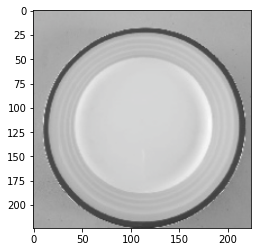

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

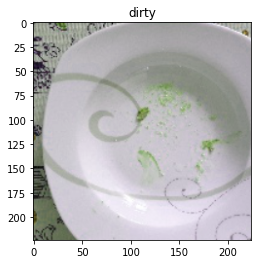

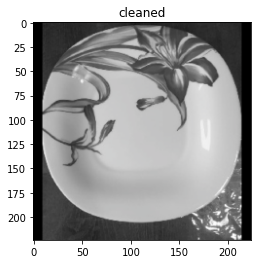

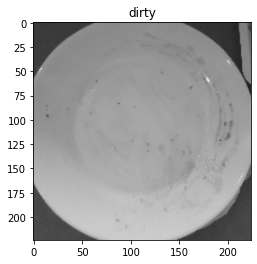

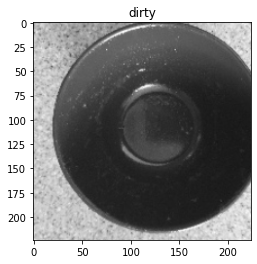

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    global epp
    epp=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            epp.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

We will use an ensemble of 3 models: resnet34, vgg16, AlexNet. For the final choice of the answer is chosen the label for which most of the models have voted (MaxVote).

P.S.When using resnet101, a small accuracy is obtained.

In [11]:
model = models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 256)
modelBN1=torch.nn.BatchNorm1d(256)
model.act=torch.nn.ReLU()
model.dr=torch.nn.Dropout(0.5) #Do not forget about retraining the model.
model.fc3 = torch.nn.Linear(256, 256) #Let's add some fully connected layers.
modelBN3=torch.nn.BatchNorm1d(256)
model.act3=torch.nn.ReLU()
model.fc4 = torch.nn.Linear(256, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
model.named_children # let's have a look at the architecture of our neural network

<bound method Module.named_children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=90);

Epoch 0/89:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 8/8 [00:00<00:00, 14.32it/s]

train Loss: 1.9107 Acc: 0.4375



100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

val Loss: 2.1044 Acc: 0.5000
Epoch 1/89:



100%|██████████| 8/8 [00:00<00:00, 16.15it/s]

train Loss: 1.1894 Acc: 0.7188



100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

val Loss: 1.3481 Acc: 0.3750
Epoch 2/89:



100%|██████████| 8/8 [00:00<00:00, 17.06it/s]

train Loss: 1.5080 Acc: 0.6562



100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

val Loss: 0.7736 Acc: 0.7500
Epoch 3/89:



100%|██████████| 8/8 [00:00<00:00, 16.71it/s]

train Loss: 1.1993 Acc: 0.7188



100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

val Loss: 0.9484 Acc: 0.7500
Epoch 4/89:



100%|██████████| 8/8 [00:00<00:00, 16.39it/s]

train Loss: 1.6340 Acc: 0.6562



100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

val Loss: 2.4159 Acc: 0.6250
Epoch 5/89:



100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

train Loss: 2.1285 Acc: 0.6562



100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

val Loss: 6.3053 Acc: 0.6250
Epoch 6/89:



100%|██████████| 8/8 [00:00<00:00, 14.73it/s]

train Loss: 4.2423 Acc: 0.5312



100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

val Loss: 0.4901 Acc: 0.7500
Epoch 7/89:



100%|██████████| 8/8 [00:00<00:00, 16.93it/s]

train Loss: 3.6734 Acc: 0.5312



100%|██████████| 2/2 [00:00<00:00,  7.53it/s]

val Loss: 1.9916 Acc: 0.8750
Epoch 8/89:



100%|██████████| 8/8 [00:00<00:00, 15.48it/s]

train Loss: 0.7424 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

val Loss: 0.0005 Acc: 1.0000
Epoch 9/89:



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

train Loss: 0.3391 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

val Loss: 1.5503 Acc: 0.5000
Epoch 10/89:



100%|██████████| 8/8 [00:00<00:00, 15.56it/s]

train Loss: 1.0227 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

val Loss: 1.5769 Acc: 0.7500
Epoch 11/89:



100%|██████████| 8/8 [00:00<00:00, 15.73it/s]

train Loss: 0.5041 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

val Loss: 2.2404 Acc: 0.8750
Epoch 12/89:



100%|██████████| 8/8 [00:00<00:00, 15.22it/s]

train Loss: 0.7332 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

val Loss: 0.8432 Acc: 0.8750
Epoch 13/89:



100%|██████████| 8/8 [00:00<00:00, 15.42it/s]

train Loss: 0.5874 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

val Loss: 2.7832 Acc: 0.7500
Epoch 14/89:



100%|██████████| 8/8 [00:00<00:00, 15.84it/s]

train Loss: 0.5942 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

val Loss: 1.0397 Acc: 0.8750
Epoch 15/89:



100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

train Loss: 0.6255 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

val Loss: 0.9695 Acc: 0.6250
Epoch 16/89:



100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

train Loss: 1.0258 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

val Loss: 1.6461 Acc: 0.8750
Epoch 17/89:



100%|██████████| 8/8 [00:00<00:00, 15.28it/s]

train Loss: 0.7728 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.18it/s]

val Loss: 0.4843 Acc: 0.8750
Epoch 18/89:



100%|██████████| 8/8 [00:00<00:00, 14.96it/s]

train Loss: 0.6001 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

val Loss: 1.2841 Acc: 0.7500
Epoch 19/89:



100%|██████████| 8/8 [00:00<00:00, 15.00it/s]

train Loss: 0.2390 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

val Loss: 0.2964 Acc: 0.8750
Epoch 20/89:



100%|██████████| 8/8 [00:00<00:00, 16.38it/s]

train Loss: 0.4324 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

val Loss: 0.0269 Acc: 1.0000
Epoch 21/89:



100%|██████████| 8/8 [00:00<00:00, 15.28it/s]

train Loss: 0.2780 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

val Loss: 0.5867 Acc: 0.8750
Epoch 22/89:



100%|██████████| 8/8 [00:00<00:00, 15.70it/s]

train Loss: 0.1242 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

val Loss: 0.9518 Acc: 0.7500
Epoch 23/89:



100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

train Loss: 0.1366 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

val Loss: 0.9052 Acc: 0.8750
Epoch 24/89:



100%|██████████| 8/8 [00:00<00:00, 14.96it/s]

train Loss: 0.3491 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

val Loss: 1.4975 Acc: 0.7500
Epoch 25/89:



100%|██████████| 8/8 [00:00<00:00, 15.55it/s]

train Loss: 0.1743 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

val Loss: 2.8180 Acc: 0.5000
Epoch 26/89:



100%|██████████| 8/8 [00:00<00:00, 16.24it/s]

train Loss: 0.1194 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

val Loss: 4.9655 Acc: 0.5000
Epoch 27/89:



100%|██████████| 8/8 [00:00<00:00, 16.45it/s]

train Loss: 0.0771 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

val Loss: 0.4978 Acc: 0.8750
Epoch 28/89:



100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

train Loss: 0.1702 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

val Loss: 0.5365 Acc: 0.7500
Epoch 29/89:



100%|██████████| 8/8 [00:00<00:00, 14.92it/s]

train Loss: 0.4352 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

val Loss: 0.0167 Acc: 1.0000
Epoch 30/89:



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

train Loss: 0.1304 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

val Loss: 0.5076 Acc: 0.8750
Epoch 31/89:



100%|██████████| 8/8 [00:00<00:00, 14.87it/s]

train Loss: 0.3593 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

val Loss: 1.7709 Acc: 0.7500
Epoch 32/89:



100%|██████████| 8/8 [00:00<00:00, 15.90it/s]

train Loss: 0.0970 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

val Loss: 2.2608 Acc: 0.6250
Epoch 33/89:



100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

train Loss: 0.4221 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

val Loss: 1.2530 Acc: 0.7500
Epoch 34/89:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

train Loss: 0.1943 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

val Loss: 0.7577 Acc: 0.8750
Epoch 35/89:



100%|██████████| 8/8 [00:00<00:00, 14.76it/s]

train Loss: 0.7030 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  7.33it/s]

val Loss: 2.9499 Acc: 0.6250
Epoch 36/89:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]


train Loss: 0.8531 Acc: 0.8750


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

val Loss: 2.6956 Acc: 0.6250
Epoch 37/89:



100%|██████████| 8/8 [00:00<00:00, 15.21it/s]

train Loss: 0.4513 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

val Loss: 1.0045 Acc: 0.6250
Epoch 38/89:



100%|██████████| 8/8 [00:00<00:00, 15.95it/s]

train Loss: 0.4928 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

val Loss: 1.9568 Acc: 0.6250
Epoch 39/89:



100%|██████████| 8/8 [00:00<00:00, 15.91it/s]

train Loss: 1.0201 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

val Loss: 1.5016 Acc: 0.6250
Epoch 40/89:



100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

train Loss: 0.5008 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

val Loss: 1.9250 Acc: 0.8750
Epoch 41/89:



100%|██████████| 8/8 [00:00<00:00, 16.27it/s]

train Loss: 0.9636 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

val Loss: 1.7376 Acc: 0.7500
Epoch 42/89:



100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

train Loss: 0.6159 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

val Loss: 1.8220 Acc: 0.6250
Epoch 43/89:



100%|██████████| 8/8 [00:00<00:00, 16.17it/s]

train Loss: 0.3258 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

val Loss: 1.2892 Acc: 0.7500
Epoch 44/89:



100%|██████████| 8/8 [00:00<00:00, 15.85it/s]

train Loss: 0.4188 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

val Loss: 1.3887 Acc: 0.7500
Epoch 45/89:



100%|██████████| 8/8 [00:00<00:00, 16.12it/s]

train Loss: 0.6073 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

val Loss: 0.4280 Acc: 0.8750
Epoch 46/89:



100%|██████████| 8/8 [00:00<00:00, 16.47it/s]

train Loss: 0.5752 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

val Loss: 1.3335 Acc: 0.7500
Epoch 47/89:



100%|██████████| 8/8 [00:00<00:00, 16.42it/s]

train Loss: 0.7207 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

val Loss: 0.4824 Acc: 0.8750
Epoch 48/89:



100%|██████████| 8/8 [00:00<00:00, 16.97it/s]

train Loss: 0.3413 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

val Loss: 2.4465 Acc: 0.5000
Epoch 49/89:



100%|██████████| 8/8 [00:00<00:00, 16.87it/s]

train Loss: 0.2644 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

val Loss: 1.7792 Acc: 0.8750
Epoch 50/89:



100%|██████████| 8/8 [00:00<00:00, 15.24it/s]

train Loss: 0.7259 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

val Loss: 0.7964 Acc: 0.6250
Epoch 51/89:



100%|██████████| 8/8 [00:00<00:00, 14.32it/s]

train Loss: 0.5674 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

val Loss: 2.6772 Acc: 0.6250
Epoch 52/89:



100%|██████████| 8/8 [00:00<00:00, 17.00it/s]

train Loss: 0.0638 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

val Loss: 1.1757 Acc: 0.7500
Epoch 53/89:



100%|██████████| 8/8 [00:00<00:00, 16.41it/s]

train Loss: 0.6750 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

val Loss: 0.8000 Acc: 0.7500
Epoch 54/89:



100%|██████████| 8/8 [00:00<00:00, 16.13it/s]

train Loss: 0.8086 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

val Loss: 1.6830 Acc: 0.8750
Epoch 55/89:



100%|██████████| 8/8 [00:00<00:00, 16.13it/s]

train Loss: 0.2675 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

val Loss: 0.7059 Acc: 0.7500
Epoch 56/89:



100%|██████████| 8/8 [00:00<00:00, 15.17it/s]

train Loss: 0.4939 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

val Loss: 0.2583 Acc: 0.8750
Epoch 57/89:



100%|██████████| 8/8 [00:00<00:00, 15.75it/s]

train Loss: 0.6550 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

val Loss: 1.7004 Acc: 0.8750
Epoch 58/89:



100%|██████████| 8/8 [00:00<00:00, 14.56it/s]

train Loss: 0.4282 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

val Loss: 0.5380 Acc: 0.7500
Epoch 59/89:



100%|██████████| 8/8 [00:00<00:00, 15.99it/s]

train Loss: 0.6218 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

val Loss: 0.1828 Acc: 0.8750
Epoch 60/89:



100%|██████████| 8/8 [00:00<00:00, 16.34it/s]

train Loss: 0.1055 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

val Loss: 1.0371 Acc: 0.6250
Epoch 61/89:



100%|██████████| 8/8 [00:00<00:00, 15.63it/s]

train Loss: 0.7783 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

val Loss: 0.7709 Acc: 0.6250
Epoch 62/89:



100%|██████████| 8/8 [00:00<00:00, 15.76it/s]

train Loss: 0.0417 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

val Loss: 2.6612 Acc: 0.7500
Epoch 63/89:



100%|██████████| 8/8 [00:00<00:00, 14.76it/s]

train Loss: 0.2833 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

val Loss: 2.2068 Acc: 0.6250
Epoch 64/89:



100%|██████████| 8/8 [00:00<00:00, 15.55it/s]

train Loss: 0.2038 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.51it/s]

val Loss: 1.5844 Acc: 0.6250
Epoch 65/89:



100%|██████████| 8/8 [00:00<00:00, 17.61it/s]

train Loss: 0.3620 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

val Loss: 0.2046 Acc: 0.8750
Epoch 66/89:



100%|██████████| 8/8 [00:00<00:00, 15.92it/s]


train Loss: 0.9349 Acc: 0.7500


100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

val Loss: 2.5996 Acc: 0.6250
Epoch 67/89:



100%|██████████| 8/8 [00:00<00:00, 15.14it/s]

train Loss: 0.0552 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

val Loss: 1.5971 Acc: 0.8750
Epoch 68/89:



100%|██████████| 8/8 [00:00<00:00, 16.02it/s]

train Loss: 0.4615 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

val Loss: 0.7374 Acc: 0.8750
Epoch 69/89:



100%|██████████| 8/8 [00:00<00:00, 15.87it/s]

train Loss: 0.4131 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

val Loss: 2.0003 Acc: 0.8750
Epoch 70/89:



100%|██████████| 8/8 [00:00<00:00, 15.38it/s]

train Loss: 0.4727 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

val Loss: 0.6760 Acc: 0.8750
Epoch 71/89:



100%|██████████| 8/8 [00:00<00:00, 16.06it/s]

train Loss: 0.2084 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.37it/s]

val Loss: 2.7109 Acc: 0.6250
Epoch 72/89:



100%|██████████| 8/8 [00:00<00:00, 15.75it/s]

train Loss: 0.1251 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

val Loss: 0.7205 Acc: 0.7500
Epoch 73/89:



100%|██████████| 8/8 [00:00<00:00, 15.65it/s]

train Loss: 0.2016 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

val Loss: 1.1846 Acc: 0.7500
Epoch 74/89:



100%|██████████| 8/8 [00:00<00:00, 15.60it/s]

train Loss: 0.0495 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

val Loss: 2.2688 Acc: 0.7500
Epoch 75/89:



100%|██████████| 8/8 [00:00<00:00, 15.69it/s]

train Loss: 0.3614 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

val Loss: 2.0314 Acc: 0.6250
Epoch 76/89:



100%|██████████| 8/8 [00:00<00:00, 15.98it/s]

train Loss: 0.1963 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

val Loss: 1.2679 Acc: 0.6250
Epoch 77/89:



100%|██████████| 8/8 [00:00<00:00, 16.04it/s]

train Loss: 0.7253 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

val Loss: 1.6339 Acc: 0.6250
Epoch 78/89:



100%|██████████| 8/8 [00:00<00:00, 14.49it/s]

train Loss: 0.0307 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

val Loss: 1.2688 Acc: 0.7500
Epoch 79/89:



100%|██████████| 8/8 [00:00<00:00, 16.18it/s]

train Loss: 0.0851 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

val Loss: 1.4153 Acc: 0.8750
Epoch 80/89:



100%|██████████| 8/8 [00:00<00:00, 15.75it/s]

train Loss: 1.4808 Acc: 0.7188



100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

val Loss: 1.3633 Acc: 0.6250
Epoch 81/89:



100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

train Loss: 0.4447 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

val Loss: 1.2555 Acc: 0.7500
Epoch 82/89:



100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

train Loss: 0.6636 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

val Loss: 1.9710 Acc: 0.6250
Epoch 83/89:



100%|██████████| 8/8 [00:00<00:00, 16.25it/s]

train Loss: 0.5894 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

val Loss: 1.5837 Acc: 0.8750
Epoch 84/89:



100%|██████████| 8/8 [00:00<00:00, 16.56it/s]

train Loss: 0.3462 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

val Loss: 0.2413 Acc: 0.8750
Epoch 85/89:



100%|██████████| 8/8 [00:00<00:00, 16.79it/s]

train Loss: 0.7357 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

val Loss: 0.1587 Acc: 0.8750
Epoch 86/89:



100%|██████████| 8/8 [00:00<00:00, 15.39it/s]

train Loss: 0.3732 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

val Loss: 2.4142 Acc: 0.6250
Epoch 87/89:



100%|██████████| 8/8 [00:00<00:00, 16.32it/s]

train Loss: 0.6778 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

val Loss: 0.4395 Acc: 0.8750
Epoch 88/89:



100%|██████████| 8/8 [00:00<00:00, 17.06it/s]

train Loss: 0.9436 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

val Loss: 0.5794 Acc: 0.8750
Epoch 89/89:



100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

train Loss: 0.2791 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

val Loss: 0.3789 Acc: 0.8750


In [14]:
model_VGG = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [15]:
model_VGG.named_children

<bound method Module.named_children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_

In [16]:
model_VGG = models.vgg16(pretrained=True)

# Disable grad for all conv layers
for param in model_VGG.parameters():
    param.requires_grad = False

model_VGG.classifier[6] = torch.nn.Linear(model_VGG.classifier[6].in_features, 2) # change the last layer to the required number of output layers

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_VGG = model_VGG.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_VGG.parameters(), lr=1.0e-3) # for this model we will use the Adam optimizer

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_model(model_VGG, loss, optimizer, scheduler, num_epochs=90);

Epoch 0/89:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 8/8 [00:00<00:00, 11.47it/s]

train Loss: 0.8022 Acc: 0.4688



100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

val Loss: 0.5326 Acc: 0.8750
Epoch 1/89:



100%|██████████| 8/8 [00:00<00:00, 12.23it/s]

train Loss: 0.4443 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

val Loss: 0.5824 Acc: 0.7500
Epoch 2/89:



100%|██████████| 8/8 [00:00<00:00, 12.61it/s]

train Loss: 0.4014 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

val Loss: 0.3501 Acc: 0.7500
Epoch 3/89:



100%|██████████| 8/8 [00:00<00:00, 12.06it/s]

train Loss: 0.2991 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

val Loss: 0.3955 Acc: 0.8750
Epoch 4/89:



100%|██████████| 8/8 [00:00<00:00, 12.30it/s]

train Loss: 0.2761 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

val Loss: 0.4970 Acc: 0.6250
Epoch 5/89:



100%|██████████| 8/8 [00:00<00:00, 12.51it/s]

train Loss: 0.2218 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

val Loss: 0.3707 Acc: 0.7500
Epoch 6/89:



100%|██████████| 8/8 [00:00<00:00, 12.42it/s]

train Loss: 0.2215 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

val Loss: 0.7244 Acc: 0.6250
Epoch 7/89:



100%|██████████| 8/8 [00:00<00:00, 11.50it/s]

train Loss: 0.1197 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

val Loss: 0.6097 Acc: 0.6250
Epoch 8/89:



100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

train Loss: 0.2206 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

val Loss: 0.5404 Acc: 0.7500
Epoch 9/89:



100%|██████████| 8/8 [00:00<00:00, 12.32it/s]

train Loss: 0.1119 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

val Loss: 0.4715 Acc: 0.7500
Epoch 10/89:



100%|██████████| 8/8 [00:00<00:00, 11.73it/s]

train Loss: 0.1623 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

val Loss: 0.4231 Acc: 0.7500
Epoch 11/89:



100%|██████████| 8/8 [00:00<00:00, 12.03it/s]

train Loss: 0.0934 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

val Loss: 0.3803 Acc: 0.7500
Epoch 12/89:



100%|██████████| 8/8 [00:00<00:00, 12.11it/s]

train Loss: 0.1965 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

val Loss: 0.4410 Acc: 0.7500
Epoch 13/89:



100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

train Loss: 0.1021 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

val Loss: 0.5555 Acc: 0.6250
Epoch 14/89:



100%|██████████| 8/8 [00:00<00:00, 11.81it/s]

train Loss: 0.0828 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

val Loss: 0.7596 Acc: 0.6250
Epoch 15/89:



100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

train Loss: 0.1323 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

val Loss: 0.6090 Acc: 0.5000
Epoch 16/89:



100%|██████████| 8/8 [00:00<00:00, 12.68it/s]

train Loss: 0.1645 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

val Loss: 0.3886 Acc: 0.6250
Epoch 17/89:



100%|██████████| 8/8 [00:00<00:00, 12.28it/s]

train Loss: 0.0731 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

val Loss: 0.5523 Acc: 0.7500
Epoch 18/89:



100%|██████████| 8/8 [00:00<00:00, 11.99it/s]

train Loss: 0.1063 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

val Loss: 0.6219 Acc: 0.6250
Epoch 19/89:



100%|██████████| 8/8 [00:00<00:00, 12.37it/s]

train Loss: 0.1192 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

val Loss: 0.7844 Acc: 0.5000
Epoch 20/89:



100%|██████████| 8/8 [00:00<00:00, 11.62it/s]

train Loss: 0.1417 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

val Loss: 0.5817 Acc: 0.7500
Epoch 21/89:



100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

train Loss: 0.1136 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

val Loss: 0.5834 Acc: 0.7500
Epoch 22/89:



100%|██████████| 8/8 [00:00<00:00, 11.53it/s]

train Loss: 0.1731 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

val Loss: 0.3786 Acc: 0.7500
Epoch 23/89:



100%|██████████| 8/8 [00:00<00:00, 12.20it/s]

train Loss: 0.1786 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

val Loss: 0.7280 Acc: 0.5000
Epoch 24/89:



100%|██████████| 8/8 [00:00<00:00, 12.35it/s]

train Loss: 0.1016 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

val Loss: 0.6431 Acc: 0.6250
Epoch 25/89:



100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

train Loss: 0.1325 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

val Loss: 0.5657 Acc: 0.5000
Epoch 26/89:



100%|██████████| 8/8 [00:00<00:00, 12.42it/s]

train Loss: 0.1016 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

val Loss: 0.7103 Acc: 0.6250
Epoch 27/89:



100%|██████████| 8/8 [00:00<00:00, 12.62it/s]

train Loss: 0.1152 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

val Loss: 0.4119 Acc: 0.6250
Epoch 28/89:



100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

train Loss: 0.1226 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

val Loss: 0.4101 Acc: 0.6250
Epoch 29/89:



100%|██████████| 8/8 [00:00<00:00, 11.84it/s]

train Loss: 0.0783 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

val Loss: 0.2560 Acc: 1.0000
Epoch 30/89:



100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

train Loss: 0.1151 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

val Loss: 0.9880 Acc: 0.3750
Epoch 31/89:



100%|██████████| 8/8 [00:00<00:00, 12.17it/s]

train Loss: 0.1282 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

val Loss: 0.6956 Acc: 0.6250
Epoch 32/89:



100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

train Loss: 0.0610 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

val Loss: 0.4210 Acc: 0.6250
Epoch 33/89:



100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

train Loss: 0.1453 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

val Loss: 0.5050 Acc: 0.5000
Epoch 34/89:



100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

train Loss: 0.1211 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

val Loss: 0.4982 Acc: 0.6250
Epoch 35/89:



100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

train Loss: 0.1741 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

val Loss: 0.2336 Acc: 1.0000
Epoch 36/89:



100%|██████████| 8/8 [00:00<00:00, 12.27it/s]

train Loss: 0.0856 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

val Loss: 0.8203 Acc: 0.7500
Epoch 37/89:



100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

train Loss: 0.1265 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

val Loss: 0.5615 Acc: 0.6250
Epoch 38/89:



100%|██████████| 8/8 [00:00<00:00, 12.42it/s]

train Loss: 0.0861 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

val Loss: 0.5423 Acc: 0.6250
Epoch 39/89:



100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

train Loss: 0.0991 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

val Loss: 0.6625 Acc: 0.5000
Epoch 40/89:



100%|██████████| 8/8 [00:00<00:00, 12.73it/s]

train Loss: 0.1505 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

val Loss: 0.3673 Acc: 0.7500
Epoch 41/89:



100%|██████████| 8/8 [00:00<00:00, 12.41it/s]

train Loss: 0.1303 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

val Loss: 0.5063 Acc: 0.7500
Epoch 42/89:



100%|██████████| 8/8 [00:00<00:00, 12.57it/s]

train Loss: 0.1550 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

val Loss: 0.6513 Acc: 0.5000
Epoch 43/89:



100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

train Loss: 0.1150 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

val Loss: 0.5783 Acc: 0.6250
Epoch 44/89:



100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

train Loss: 0.1104 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

val Loss: 0.4140 Acc: 0.7500
Epoch 45/89:



100%|██████████| 8/8 [00:00<00:00, 11.74it/s]

train Loss: 0.1085 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

val Loss: 0.6358 Acc: 0.6250
Epoch 46/89:



100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

train Loss: 0.0985 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

val Loss: 0.6427 Acc: 0.5000
Epoch 47/89:



100%|██████████| 8/8 [00:00<00:00, 12.74it/s]

train Loss: 0.1516 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

val Loss: 0.4419 Acc: 0.7500
Epoch 48/89:



100%|██████████| 8/8 [00:00<00:00, 12.62it/s]

train Loss: 0.1530 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

val Loss: 0.4353 Acc: 0.7500
Epoch 49/89:



100%|██████████| 8/8 [00:00<00:00, 12.37it/s]

train Loss: 0.1333 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

val Loss: 0.9388 Acc: 0.5000
Epoch 50/89:



100%|██████████| 8/8 [00:00<00:00, 12.21it/s]

train Loss: 0.1727 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

val Loss: 0.6157 Acc: 0.6250
Epoch 51/89:



100%|██████████| 8/8 [00:00<00:00, 12.25it/s]

train Loss: 0.1473 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

val Loss: 0.3701 Acc: 0.7500
Epoch 52/89:



100%|██████████| 8/8 [00:00<00:00, 12.01it/s]

train Loss: 0.1497 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

val Loss: 0.5554 Acc: 0.7500
Epoch 53/89:



100%|██████████| 8/8 [00:00<00:00, 11.68it/s]

train Loss: 0.1356 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

val Loss: 0.6902 Acc: 0.5000
Epoch 54/89:



100%|██████████| 8/8 [00:00<00:00, 12.52it/s]

train Loss: 0.1773 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

val Loss: 0.2559 Acc: 1.0000
Epoch 55/89:



100%|██████████| 8/8 [00:00<00:00, 12.43it/s]

train Loss: 0.1017 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

val Loss: 0.5504 Acc: 0.7500
Epoch 56/89:



100%|██████████| 8/8 [00:00<00:00, 12.48it/s]

train Loss: 0.1132 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

val Loss: 0.6230 Acc: 0.6250
Epoch 57/89:



100%|██████████| 8/8 [00:00<00:00, 11.85it/s]

train Loss: 0.1733 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

val Loss: 0.6262 Acc: 0.7500
Epoch 58/89:



100%|██████████| 8/8 [00:00<00:00, 12.27it/s]

train Loss: 0.0648 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

val Loss: 0.4231 Acc: 0.6250
Epoch 59/89:



100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

train Loss: 0.1040 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

val Loss: 0.5228 Acc: 0.7500
Epoch 60/89:



100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

train Loss: 0.1624 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

val Loss: 0.5928 Acc: 0.3750
Epoch 61/89:



100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

train Loss: 0.0842 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

val Loss: 0.5955 Acc: 0.7500
Epoch 62/89:



100%|██████████| 8/8 [00:00<00:00, 12.61it/s]

train Loss: 0.1373 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

val Loss: 0.7148 Acc: 0.3750
Epoch 63/89:



100%|██████████| 8/8 [00:00<00:00, 12.48it/s]

train Loss: 0.1426 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

val Loss: 0.3477 Acc: 0.7500
Epoch 64/89:



100%|██████████| 8/8 [00:00<00:00, 12.62it/s]

train Loss: 0.1001 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

val Loss: 0.4581 Acc: 0.5000
Epoch 65/89:



100%|██████████| 8/8 [00:00<00:00, 12.19it/s]

train Loss: 0.0946 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

val Loss: 0.6393 Acc: 0.6250
Epoch 66/89:



100%|██████████| 8/8 [00:00<00:00, 12.35it/s]

train Loss: 0.1448 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

val Loss: 0.6928 Acc: 0.5000
Epoch 67/89:



100%|██████████| 8/8 [00:00<00:00, 13.06it/s]

train Loss: 0.2088 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

val Loss: 0.3040 Acc: 0.8750
Epoch 68/89:



100%|██████████| 8/8 [00:00<00:00, 12.43it/s]

train Loss: 0.1456 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

val Loss: 0.6380 Acc: 0.6250
Epoch 69/89:



100%|██████████| 8/8 [00:00<00:00, 12.56it/s]

train Loss: 0.1413 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

val Loss: 0.6336 Acc: 0.6250
Epoch 70/89:



100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

train Loss: 0.2048 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

val Loss: 0.5905 Acc: 0.6250
Epoch 71/89:



100%|██████████| 8/8 [00:00<00:00, 12.46it/s]

train Loss: 0.1386 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

val Loss: 0.4225 Acc: 0.6250
Epoch 72/89:



100%|██████████| 8/8 [00:00<00:00, 12.29it/s]

train Loss: 0.1552 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

val Loss: 0.6575 Acc: 0.6250
Epoch 73/89:



100%|██████████| 8/8 [00:00<00:00, 12.95it/s]

train Loss: 0.0869 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

val Loss: 0.6842 Acc: 0.5000
Epoch 74/89:



100%|██████████| 8/8 [00:00<00:00, 11.59it/s]

train Loss: 0.1455 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

val Loss: 0.5933 Acc: 0.7500
Epoch 75/89:



100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

train Loss: 0.0964 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

val Loss: 0.7758 Acc: 0.7500
Epoch 76/89:



100%|██████████| 8/8 [00:00<00:00, 12.23it/s]

train Loss: 0.0844 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

val Loss: 0.7417 Acc: 0.5000
Epoch 77/89:



100%|██████████| 8/8 [00:00<00:00, 12.63it/s]

train Loss: 0.0820 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

val Loss: 0.2813 Acc: 0.8750
Epoch 78/89:



100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

train Loss: 0.1066 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

val Loss: 0.5736 Acc: 0.7500
Epoch 79/89:



100%|██████████| 8/8 [00:00<00:00, 12.41it/s]

train Loss: 0.1303 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

val Loss: 0.4968 Acc: 0.6250
Epoch 80/89:



100%|██████████| 8/8 [00:00<00:00, 11.82it/s]

train Loss: 0.1059 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

val Loss: 0.4466 Acc: 0.7500
Epoch 81/89:



100%|██████████| 8/8 [00:00<00:00, 12.23it/s]

train Loss: 0.1747 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

val Loss: 0.9035 Acc: 0.5000
Epoch 82/89:



100%|██████████| 8/8 [00:00<00:00, 11.83it/s]

train Loss: 0.1114 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

val Loss: 0.8740 Acc: 0.3750
Epoch 83/89:



100%|██████████| 8/8 [00:00<00:00, 12.45it/s]

train Loss: 0.1363 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

val Loss: 0.4690 Acc: 0.7500
Epoch 84/89:



100%|██████████| 8/8 [00:00<00:00, 12.61it/s]

train Loss: 0.1231 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

val Loss: 0.5797 Acc: 0.5000
Epoch 85/89:



100%|██████████| 8/8 [00:00<00:00, 12.26it/s]

train Loss: 0.1222 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

val Loss: 0.4926 Acc: 0.5000
Epoch 86/89:



100%|██████████| 8/8 [00:00<00:00, 12.08it/s]

train Loss: 0.1997 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

val Loss: 0.8252 Acc: 0.6250
Epoch 87/89:



100%|██████████| 8/8 [00:00<00:00, 12.33it/s]

train Loss: 0.1541 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

val Loss: 0.8806 Acc: 0.3750
Epoch 88/89:



100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

train Loss: 0.2150 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

val Loss: 0.6474 Acc: 0.7500
Epoch 89/89:



100%|██████████| 8/8 [00:00<00:00, 12.37it/s]

train Loss: 0.1305 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

val Loss: 0.7099 Acc: 0.5000


In [17]:
model_Ale = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True) # model upload

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [18]:
model_Ale.named_children

<bound method Module.named_children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_feature

In [19]:

# Disable grad for all conv layers
for param in model_Ale.parameters():
    param.requires_grad = False

model_Ale.classifier[6] = torch.nn.Linear(model_Ale.classifier[6].in_features, 2)
#model_Ale.act=torch.nn.ReLU()
#model_Ale.dr=torch.nn.Dropout(0.5)
#model_Ale.fc3 = torch.nn.Linear(256, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_Ale = model_Ale.to(device)

In [20]:
model_Ale.named_children

<bound method Module.named_children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_feature

In [21]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Ale.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_model(model_Ale, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 8/8 [00:00<00:00, 15.64it/s]

train Loss: 1.0643 Acc: 0.4062



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.8966 Acc: 0.5000
Epoch 1/99:



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

train Loss: 0.4392 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

val Loss: 0.6901 Acc: 0.6250
Epoch 2/99:



100%|██████████| 8/8 [00:00<00:00, 17.25it/s]

train Loss: 0.3467 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

val Loss: 0.4613 Acc: 0.8750
Epoch 3/99:



100%|██████████| 8/8 [00:00<00:00, 15.30it/s]

train Loss: 0.2152 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

val Loss: 0.5784 Acc: 0.7500
Epoch 4/99:



100%|██████████| 8/8 [00:00<00:00, 15.76it/s]

train Loss: 0.1362 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

val Loss: 0.4670 Acc: 0.8750
Epoch 5/99:



100%|██████████| 8/8 [00:00<00:00, 16.15it/s]

train Loss: 0.2731 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

val Loss: 0.9780 Acc: 0.7500
Epoch 6/99:



100%|██████████| 8/8 [00:00<00:00, 15.65it/s]

train Loss: 0.2672 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

val Loss: 0.5514 Acc: 0.7500
Epoch 7/99:



100%|██████████| 8/8 [00:00<00:00, 16.09it/s]


train Loss: 0.1136 Acc: 0.9375


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.8727 Acc: 0.6250
Epoch 8/99:



100%|██████████| 8/8 [00:00<00:00, 14.99it/s]

train Loss: 0.1884 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

val Loss: 0.5574 Acc: 0.7500
Epoch 9/99:



100%|██████████| 8/8 [00:00<00:00, 15.81it/s]

train Loss: 0.1384 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

val Loss: 0.6678 Acc: 0.7500
Epoch 10/99:



100%|██████████| 8/8 [00:00<00:00, 15.70it/s]

train Loss: 0.0845 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

val Loss: 0.5777 Acc: 0.7500
Epoch 11/99:



100%|██████████| 8/8 [00:00<00:00, 16.41it/s]

train Loss: 0.0784 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

val Loss: 0.5977 Acc: 0.7500
Epoch 12/99:



100%|██████████| 8/8 [00:00<00:00, 15.27it/s]

train Loss: 0.0487 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.7916 Acc: 0.6250
Epoch 13/99:



100%|██████████| 8/8 [00:00<00:00, 16.03it/s]

train Loss: 0.0932 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

val Loss: 0.6309 Acc: 0.7500
Epoch 14/99:



100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

train Loss: 0.0644 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.8457 Acc: 0.6250
Epoch 15/99:



100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

train Loss: 0.0714 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.7516 Acc: 0.6250
Epoch 16/99:



100%|██████████| 8/8 [00:00<00:00, 15.88it/s]

train Loss: 0.0645 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

val Loss: 0.6335 Acc: 0.7500
Epoch 17/99:



100%|██████████| 8/8 [00:00<00:00, 15.22it/s]


train Loss: 0.1827 Acc: 0.9062


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

val Loss: 0.5711 Acc: 0.7500
Epoch 18/99:



100%|██████████| 8/8 [00:00<00:00, 15.48it/s]

train Loss: 0.1811 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

val Loss: 0.4795 Acc: 0.7500
Epoch 19/99:



100%|██████████| 8/8 [00:00<00:00, 15.63it/s]

train Loss: 0.2464 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

val Loss: 0.5078 Acc: 0.7500
Epoch 20/99:



100%|██████████| 8/8 [00:00<00:00, 15.81it/s]

train Loss: 0.0744 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.5303 Acc: 0.7500
Epoch 21/99:



100%|██████████| 8/8 [00:00<00:00, 16.18it/s]

train Loss: 0.0817 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

val Loss: 0.5951 Acc: 0.7500
Epoch 22/99:



100%|██████████| 8/8 [00:00<00:00, 16.23it/s]

train Loss: 0.1297 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

val Loss: 0.8960 Acc: 0.6250
Epoch 23/99:



100%|██████████| 8/8 [00:00<00:00, 15.48it/s]

train Loss: 0.0673 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

val Loss: 0.4080 Acc: 0.7500
Epoch 24/99:



100%|██████████| 8/8 [00:00<00:00, 16.20it/s]

train Loss: 0.1850 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

val Loss: 0.6032 Acc: 0.7500
Epoch 25/99:



100%|██████████| 8/8 [00:00<00:00, 16.69it/s]

train Loss: 0.1534 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

val Loss: 0.4642 Acc: 0.7500
Epoch 26/99:



100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

train Loss: 0.0771 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

val Loss: 0.5610 Acc: 0.7500
Epoch 27/99:



100%|██████████| 8/8 [00:00<00:00, 16.10it/s]

train Loss: 0.0495 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

val Loss: 0.8836 Acc: 0.6250
Epoch 28/99:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

train Loss: 0.1062 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

val Loss: 0.4997 Acc: 0.7500
Epoch 29/99:



100%|██████████| 8/8 [00:00<00:00, 16.46it/s]

train Loss: 0.0943 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

val Loss: 0.8417 Acc: 0.6250
Epoch 30/99:



100%|██████████| 8/8 [00:00<00:00, 16.37it/s]

train Loss: 0.0499 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

val Loss: 0.4864 Acc: 0.7500
Epoch 31/99:



100%|██████████| 8/8 [00:00<00:00, 16.02it/s]

train Loss: 0.2389 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

val Loss: 0.5611 Acc: 0.7500
Epoch 32/99:



100%|██████████| 8/8 [00:00<00:00, 15.59it/s]

train Loss: 0.1381 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

val Loss: 0.4977 Acc: 0.6250
Epoch 33/99:



100%|██████████| 8/8 [00:00<00:00, 16.35it/s]

train Loss: 0.0825 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

val Loss: 0.6071 Acc: 0.7500
Epoch 34/99:



100%|██████████| 8/8 [00:00<00:00, 15.91it/s]

train Loss: 0.0790 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

val Loss: 0.4332 Acc: 0.7500
Epoch 35/99:



100%|██████████| 8/8 [00:00<00:00, 15.24it/s]

train Loss: 0.1005 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

val Loss: 0.5510 Acc: 0.7500
Epoch 36/99:



100%|██████████| 8/8 [00:00<00:00, 16.05it/s]

train Loss: 0.1537 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

val Loss: 0.5790 Acc: 0.7500
Epoch 37/99:



100%|██████████| 8/8 [00:00<00:00, 15.31it/s]

train Loss: 0.0379 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.5828 Acc: 0.7500
Epoch 38/99:



100%|██████████| 8/8 [00:00<00:00, 16.31it/s]

train Loss: 0.0809 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.5332 Acc: 0.7500
Epoch 39/99:



100%|██████████| 8/8 [00:00<00:00, 16.27it/s]

train Loss: 0.0720 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

val Loss: 0.9252 Acc: 0.6250
Epoch 40/99:



100%|██████████| 8/8 [00:00<00:00, 16.44it/s]

train Loss: 0.0554 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

val Loss: 0.5540 Acc: 0.7500
Epoch 41/99:



100%|██████████| 8/8 [00:00<00:00, 16.03it/s]

train Loss: 0.0735 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.4931 Acc: 0.7500
Epoch 42/99:



100%|██████████| 8/8 [00:00<00:00, 15.66it/s]

train Loss: 0.1313 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

val Loss: 0.6137 Acc: 0.7500
Epoch 43/99:



100%|██████████| 8/8 [00:00<00:00, 16.25it/s]

train Loss: 0.1617 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

val Loss: 0.5455 Acc: 0.7500
Epoch 44/99:



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

train Loss: 0.1761 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

val Loss: 0.4625 Acc: 0.7500
Epoch 45/99:



100%|██████████| 8/8 [00:00<00:00, 15.62it/s]

train Loss: 0.0518 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

val Loss: 0.5579 Acc: 0.7500
Epoch 46/99:



100%|██████████| 8/8 [00:00<00:00, 16.71it/s]

train Loss: 0.2029 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

val Loss: 0.6741 Acc: 0.7500
Epoch 47/99:



100%|██████████| 8/8 [00:00<00:00, 15.75it/s]

train Loss: 0.1233 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

val Loss: 0.4640 Acc: 0.7500
Epoch 48/99:



100%|██████████| 8/8 [00:00<00:00, 16.13it/s]

train Loss: 0.1171 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

val Loss: 0.5387 Acc: 0.7500
Epoch 49/99:



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

train Loss: 0.1397 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

val Loss: 1.0549 Acc: 0.6250
Epoch 50/99:



100%|██████████| 8/8 [00:00<00:00, 15.95it/s]

train Loss: 0.0618 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.4722 Acc: 0.7500
Epoch 51/99:



100%|██████████| 8/8 [00:00<00:00, 15.72it/s]

train Loss: 0.2169 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

val Loss: 1.0805 Acc: 0.6250
Epoch 52/99:



100%|██████████| 8/8 [00:00<00:00, 15.70it/s]

train Loss: 0.1372 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

val Loss: 0.8962 Acc: 0.6250
Epoch 53/99:



100%|██████████| 8/8 [00:00<00:00, 15.87it/s]

train Loss: 0.1745 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

val Loss: 0.6538 Acc: 0.7500
Epoch 54/99:



100%|██████████| 8/8 [00:00<00:00, 15.32it/s]

train Loss: 0.1867 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

val Loss: 1.0856 Acc: 0.6250
Epoch 55/99:



100%|██████████| 8/8 [00:00<00:00, 15.52it/s]

train Loss: 0.0721 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

val Loss: 0.5305 Acc: 0.7500
Epoch 56/99:



100%|██████████| 8/8 [00:00<00:00, 15.54it/s]

train Loss: 0.0769 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

val Loss: 0.5314 Acc: 0.7500
Epoch 57/99:



100%|██████████| 8/8 [00:00<00:00, 16.31it/s]

train Loss: 0.0612 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

val Loss: 0.5128 Acc: 0.7500
Epoch 58/99:



100%|██████████| 8/8 [00:00<00:00, 15.65it/s]

train Loss: 0.0479 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

val Loss: 0.6735 Acc: 0.7500
Epoch 59/99:



100%|██████████| 8/8 [00:00<00:00, 16.39it/s]

train Loss: 0.0558 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

val Loss: 0.9877 Acc: 0.6250
Epoch 60/99:



100%|██████████| 8/8 [00:00<00:00, 16.51it/s]

train Loss: 0.0457 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

val Loss: 0.9234 Acc: 0.6250
Epoch 61/99:



100%|██████████| 8/8 [00:00<00:00, 15.93it/s]

train Loss: 0.2118 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

val Loss: 0.4822 Acc: 0.7500
Epoch 62/99:



100%|██████████| 8/8 [00:00<00:00, 15.96it/s]

train Loss: 0.0883 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

val Loss: 0.4810 Acc: 0.7500
Epoch 63/99:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

train Loss: 0.0533 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

val Loss: 0.7427 Acc: 0.6250
Epoch 64/99:



100%|██████████| 8/8 [00:00<00:00, 16.02it/s]

train Loss: 0.0848 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

val Loss: 0.5137 Acc: 0.7500
Epoch 65/99:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

train Loss: 0.1378 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

val Loss: 0.6874 Acc: 0.7500
Epoch 66/99:



100%|██████████| 8/8 [00:00<00:00, 14.62it/s]

train Loss: 0.2529 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

val Loss: 0.4300 Acc: 0.7500
Epoch 67/99:



100%|██████████| 8/8 [00:00<00:00, 15.25it/s]

train Loss: 0.1791 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

val Loss: 0.4023 Acc: 0.7500
Epoch 68/99:



100%|██████████| 8/8 [00:00<00:00, 16.43it/s]

train Loss: 0.1308 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.6655 Acc: 0.6250
Epoch 69/99:



100%|██████████| 8/8 [00:00<00:00, 17.07it/s]

train Loss: 0.0792 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

val Loss: 0.4987 Acc: 0.7500
Epoch 70/99:



100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

train Loss: 0.1825 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

val Loss: 0.6003 Acc: 0.7500
Epoch 71/99:



100%|██████████| 8/8 [00:00<00:00, 14.39it/s]

train Loss: 0.0978 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

val Loss: 0.9720 Acc: 0.6250
Epoch 72/99:



100%|██████████| 8/8 [00:00<00:00, 15.72it/s]

train Loss: 0.1393 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

val Loss: 0.5790 Acc: 0.6250
Epoch 73/99:



100%|██████████| 8/8 [00:00<00:00, 15.99it/s]

train Loss: 0.0528 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

val Loss: 1.0486 Acc: 0.6250
Epoch 74/99:



100%|██████████| 8/8 [00:00<00:00, 16.17it/s]

train Loss: 0.0367 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

val Loss: 0.9150 Acc: 0.6250
Epoch 75/99:



100%|██████████| 8/8 [00:00<00:00, 15.28it/s]

train Loss: 0.0312 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

val Loss: 0.6104 Acc: 0.7500
Epoch 76/99:



100%|██████████| 8/8 [00:00<00:00, 16.29it/s]

train Loss: 0.0620 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

val Loss: 0.5601 Acc: 0.7500
Epoch 77/99:



100%|██████████| 8/8 [00:00<00:00, 16.51it/s]

train Loss: 0.0573 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

val Loss: 0.6202 Acc: 0.7500
Epoch 78/99:



100%|██████████| 8/8 [00:00<00:00, 15.56it/s]

train Loss: 0.1043 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

val Loss: 0.5562 Acc: 0.7500
Epoch 79/99:



100%|██████████| 8/8 [00:00<00:00, 15.24it/s]

train Loss: 0.1068 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

val Loss: 0.8894 Acc: 0.6250
Epoch 80/99:



100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

train Loss: 0.1052 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

val Loss: 0.7152 Acc: 0.7500
Epoch 81/99:



100%|██████████| 8/8 [00:00<00:00, 16.18it/s]

train Loss: 0.1379 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

val Loss: 0.9820 Acc: 0.6250
Epoch 82/99:



100%|██████████| 8/8 [00:00<00:00, 15.26it/s]

train Loss: 0.0941 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

val Loss: 0.9960 Acc: 0.6250
Epoch 83/99:



100%|██████████| 8/8 [00:00<00:00, 14.12it/s]

train Loss: 0.1001 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

val Loss: 0.6376 Acc: 0.6250
Epoch 84/99:



100%|██████████| 8/8 [00:00<00:00, 16.36it/s]

train Loss: 0.0944 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.4556 Acc: 0.7500
Epoch 85/99:



100%|██████████| 8/8 [00:00<00:00, 15.84it/s]

train Loss: 0.0481 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

val Loss: 0.8509 Acc: 0.7500
Epoch 86/99:



100%|██████████| 8/8 [00:00<00:00, 16.31it/s]

train Loss: 0.0938 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

val Loss: 0.5504 Acc: 0.7500
Epoch 87/99:



100%|██████████| 8/8 [00:00<00:00, 15.44it/s]

train Loss: 0.0493 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

val Loss: 0.5717 Acc: 0.7500
Epoch 88/99:



100%|██████████| 8/8 [00:00<00:00, 15.66it/s]

train Loss: 0.0726 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

val Loss: 0.4862 Acc: 0.7500
Epoch 89/99:



100%|██████████| 8/8 [00:00<00:00, 16.47it/s]

train Loss: 0.0964 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

val Loss: 0.6194 Acc: 0.7500
Epoch 90/99:



100%|██████████| 8/8 [00:00<00:00, 14.82it/s]

train Loss: 0.0558 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

val Loss: 0.5276 Acc: 0.7500
Epoch 91/99:



100%|██████████| 8/8 [00:00<00:00, 15.99it/s]

train Loss: 0.0738 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

val Loss: 0.5038 Acc: 0.7500
Epoch 92/99:



100%|██████████| 8/8 [00:00<00:00, 15.46it/s]

train Loss: 0.1893 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

val Loss: 0.9603 Acc: 0.6250
Epoch 93/99:



100%|██████████| 8/8 [00:00<00:00, 15.83it/s]

train Loss: 0.1064 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

val Loss: 0.4127 Acc: 0.7500
Epoch 94/99:



100%|██████████| 8/8 [00:00<00:00, 15.77it/s]

train Loss: 0.2359 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

val Loss: 0.5215 Acc: 0.7500
Epoch 95/99:



100%|██████████| 8/8 [00:00<00:00, 15.92it/s]

train Loss: 0.0420 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

val Loss: 0.8295 Acc: 0.6250
Epoch 96/99:



100%|██████████| 8/8 [00:00<00:00, 16.00it/s]

train Loss: 0.1202 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

val Loss: 1.0448 Acc: 0.6250
Epoch 97/99:



100%|██████████| 8/8 [00:00<00:00, 15.56it/s]

train Loss: 0.1543 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

val Loss: 0.6201 Acc: 0.7500
Epoch 98/99:



100%|██████████| 8/8 [00:00<00:00, 16.24it/s]

train Loss: 0.0790 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

val Loss: 0.6014 Acc: 0.7500
Epoch 99/99:



100%|██████████| 8/8 [00:00<00:00, 15.77it/s]

train Loss: 0.0379 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

val Loss: 0.9695 Acc: 0.6250


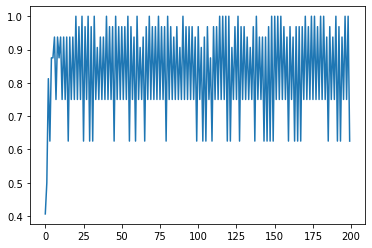

In [22]:
import matplotlib.pyplot as plt

plt.plot(epp)# let's look at the "general" accuracy chart depending on the epoch

In [24]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: ignored

In [27]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [28]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /content/test
    StandardTransform
Transform: Compose(
               RandomPerspective(p=0.1)
               RandomChoice(
               CenterCrop(size=(180, 180))
               CenterCrop(size=(160, 160))
               Compose(
               CenterCrop(size=(280, 280))
               Grayscale(num_output_channels=3)
           )
               Compose(
               CenterCrop(size=(200, 200))
               Grayscale(num_output_channels=3)
           )
           )
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=(0.1, 0.2))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [29]:
model.eval()
#resnet
test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs) # predict the test data using the resnet model
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)  
test_predictions = np.concatenate(test_predictions)
print('vgg16')


100%|██████████| 186/186 [00:08<00:00, 20.72it/s]

vgg16


In [30]:
#vgg16
test_predictions_vgg = []
test_img_paths_vgg = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model_VGG(inputs)    # let's predict the test data using the vgg model
    test_predictions_vgg.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths_vgg.extend(paths)
    
test_predictions_vgg = np.concatenate(test_predictions_vgg)


100%|██████████| 186/186 [00:10<00:00, 17.42it/s]


In [31]:
print('alexnet')
#Alexnet
test_predictions_ale = []
test_img_paths_ale = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model_Ale(inputs)         # let's predict the test data using the alexnet model
    test_predictions_ale.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths_ale.extend(paths)
    
test_predictions_ale = np.concatenate(test_predictions_ale)


  2%|▏         | 4/186 [00:00<00:05, 35.19it/s]

alexnet


100%|██████████| 186/186 [00:06<00:00, 28.36it/s]


In [32]:
print(len(test_predictions),len(test_predictions_vgg),len(test_predictions_ale))

744 744 744


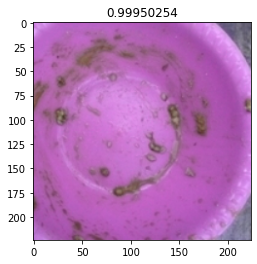

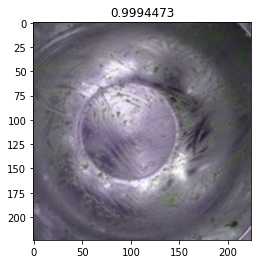

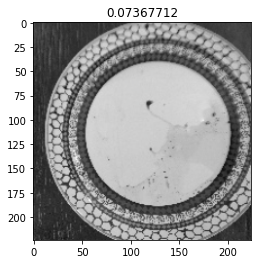

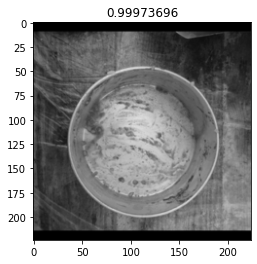

In [33]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions_ale):
    show_input(img, title=pred)

In [ ]:
# if the model predicts a class with a probability of 0.8, then we refer it to the first model. 
#If two or more models have voted for this class, then we believe that this prediction is reliable.
ch=0
itog=[]
for i in range(len(test_predictions)):
  ch=0
  if test_predictions[i]>0.8:
    ch+=ch
  if test_predictions_vgg[i]>0.8:
    ch+=ch
  if test_predictions_ale[i]>0.8:
    ch+=ch
  if(ch>=2):
    itog.append(1)
  else:
    itog.append(0)


In [ ]:
itog[:5] #check it

[1, 1, 0, 1, 0]

In [ ]:
#submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': itog})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,cleaned
0005,dirty


In [ ]:
submission_df.to_csv('submissionens888.csv')

In [ ]:
!rm -rf train val test